In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd
from scipy.optimize import minimize

In [2]:
# 価格を生成する関数
def create_price(r_min: float, r_max: float, M: int) -> NDArray[np.float_]:
    # r_minとr_maxの間のランダムな0.1刻みの少数をM個生成
    price = np.random.uniform(r_min, r_max, M)
    price = np.round(price, 1)

    return price


# alphaを作成する関数
def alpha_star(M: int) -> NDArray[np.float_]:
    alpha_star = np.random.uniform(M, 3 * M, size=M)
    return alpha_star


# betaを作成する関数
def beta_star(M: int, M_prime: int) -> NDArray[np.float_]:
    beta_star = np.zeros((M, M_prime))

    for m in range(M):
        for m_prime in range(M_prime):
            if m == m_prime:
                beta_star[m, m_prime] = np.random.uniform(-2 * M, -M)
            else:
                beta_star[m, m_prime] = np.random.uniform(0, 1)

    return beta_star


def quantity_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    quantity_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta + 1 * np.random.normal(0, 5)
        quantity_list.append(quantity)
    # print("quantity_list", quantity_list)

    return quantity_list


def sales_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    sales_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        sales_list.append(quantity * price[m])

    return sales_list

In [3]:
# 目的関数を定義
def predict_objective_function(
    prices: NDArray[np.float_], intercepts: [float], coefs: [NDArray[np.float_]], M: int
) -> float:
    # 各変数の内容をデバッグ出力
    # print("prices:", prices)
    # print("intercepts:", intercepts)
    # print("coefs:", coefs)
    # print("M:", M)

    return -sum(
        prices[m]
        * (intercepts[m] + sum(coefs[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )

In [4]:
# 目的関数を定義（最大化問題を最小化問題に変換）
def sales_objective_function(prices, alpha, beta, M):
    return -sum(
        prices[m] * (alpha[m] + sum(beta[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )

In [5]:
# 予測と最適化を行う関数
def predict_optimize(
    M: int, X: NDArray[np.float_], Y: NDArray[np.float_], prices_list: list[float]
) -> tuple[float, NDArray[np.float_]]:
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)
    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 各価格の範囲を設定（0.6から1.0）
    bounds = [(0.6, 1.0) for _ in range(M)]
    # 最適化を実行
    result = minimize(
        predict_objective_function,
        initial_prices,
        args=(intercepts, coefs, M),
        bounds=bounds,
        method="SLSQP",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices

In [6]:
def sales_optimize(
    M: int,
    alpha: np.ndarray,
    beta: np.ndarray,
    prices_list: list[float],
) -> tuple[float, np.ndarray]:
    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 各価格の範囲を設定（0.6から1.0）
    bounds = [(0.6, 1.0) for _ in range(M)]
    # 最適化を実行
    result = minimize(
        sales_objective_function,
        initial_prices,
        args=(alpha, beta, M),
        bounds=bounds,
        method="SLSQP",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices

In [7]:
# CVを行う関数
def cross_validation(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    prices_list: list[float],
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []
    Z = len(prices_list)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）
        bounds = [(0.6, 1.0) for _ in range(M)]
        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="SLSQP",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x
        optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return np.mean(optimal_sales_list)

In [8]:
# このデータにおけるalpha,betaを作成
M = 20
alpha = alpha_star(M)
beta = beta_star(M, M)
r_m = 0.6
r_M = 1.0
# 価格を入れるリスト
price_list = []
# 売上を入れるリスト
sales_list = []

# 価格と対応する売上を500件生成
for i in range(500):
    price = create_price(r_m, r_M, M)
    price_list.append(price)
    sales = quantity_function(price, alpha, beta)
    sales_list.append(sales)

X = np.array(price_list).astype(float)
y = np.array(sales_list).astype(float)

z = [0.6, 0.7, 0.8, 0.9, 1.0]

# 予測と最適化を行う関数
optimal_value, optimal_prices = predict_optimize(M, X, y, z)

# salesと最適化を行う関数
optimal_value_sales, optimal_prices_sales = sales_optimize(M, alpha, beta, z)

# optimal_prices = np.round(optimal_prices, 1)をsales_functionに入れて売上を計算
sales = sum(sales_function(optimal_prices, alpha, beta))

# cvを行う関数
cv = cross_validation(X, y, M, 5, z)

print("optimal_prices", optimal_prices)
print("optimal_value", optimal_value)
print("optimal_prices_sales", optimal_prices_sales)
print("optimal_value_sales", optimal_value_sales)
print("cv", cv)
print("sales", sales)

optimal_prices [0.89225688 0.88665391 0.6        1.         0.78366299 0.67049938
 0.82898344 0.71396403 0.78910842 0.70925741 0.6        1.
 0.66332579 0.6        0.80253176 0.72910314 0.81574863 0.7288402
 1.         0.90010967]
optimal_value 330.5176123576835
optimal_prices_sales [0.94973683 0.73280073 0.6        1.         0.72067861 0.66998796
 0.79016098 0.64755746 0.93492224 0.61843064 0.64424266 1.
 0.90369683 0.6        0.82416181 0.68409867 0.72657633 0.77141674
 1.         0.81017337]
optimal_value_sales 328.9710362215296
cv 313.843298372405
sales 324.2494980758886


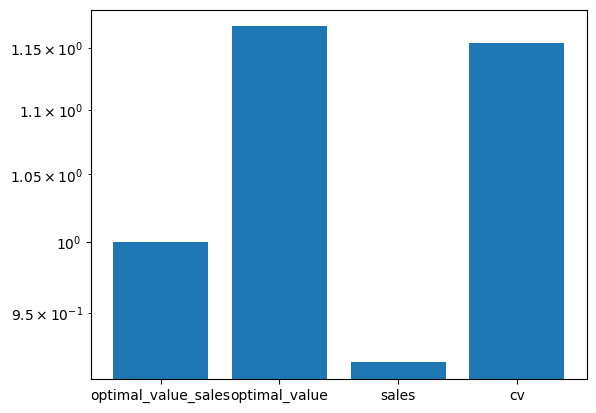

In [40]:
# 結果を棒グラフで表示

# データの準備
labels = ["optimal_value_sales", "optimal_value", "sales", "cv"]
values = [
    optimal_value_sales / optimal_value_sales,
    optimal_value / optimal_value_sales,
    sales / optimal_value_sales,
    cv / optimal_value_sales,
]

# グラフの描画
plt.bar(labels, values)

# logスケールに設定
plt.yscale("log")

# グラフの表示
plt.show()

In [22]:
# M=20で100回実行し、平均をプロット
M = 20

# listを作成
optimal_value_list = []
optimal_value_sales_list = []
cv_list = []
price_sales_list = []
for i in range(100):
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    price_list = []
    sales_list = []

    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    optimal_value, optimal_prices = predict_optimize(M, X, y, z)
    optimal_value_sales, optimal_prices_sales = sales_optimize(M, alpha, beta, z)
    price_sales = sum(sales_function(optimal_prices, alpha, beta))
    cv = cross_validation(X, y, M, 5, z)

    print(price_sales)

    optimal_value_sales_list.append(optimal_value_sales / optimal_value_sales)
    optimal_value_list.append(optimal_value / optimal_value_sales)
    cv_list.append(cv / optimal_value_sales)
    price_sales_list.append(price_sales / optimal_value_sales)

# 結果を棒グラフで表示
print(sales_list)
# データの準備

339.42636974509486
358.4558497587163
409.24395810929747
366.4277512624454
445.0179357074042
413.24045419324307
379.77031611211163
309.33948617784824
515.0607839708173
343.16914791864343
415.3153022900201
335.6443567262715
425.08609937282574
293.62229788979084
391.3972288430067
373.47778026152145
422.3123940829168
429.68326028809565
371.4379401004479
482.4674750996886
425.8905332838069
429.9298133297446
377.9988809707947
406.0930631420844
407.0318772020109
371.99137934247426
416.9407567735554
376.5538232546252
421.21395232249535
513.2737933024449
494.3181994887428
503.96169471188233
342.1218893849155
441.125035646288
382.1358468237303
379.71257845828814
323.9551457368507
371.5579668082823
336.03735882751454
370.9102175316325
471.765065226461
423.2060856913543
394.51285843895823
456.1262730784929
419.3309442993445
395.78042087504167
404.3742892148805
541.2978364350648
511.2855912640001
548.7898020982115
464.2269920479955
468.8707277692666
336.90774291630333
341.507140191573
439.029277703

In [23]:
len(price_sales_list)

100

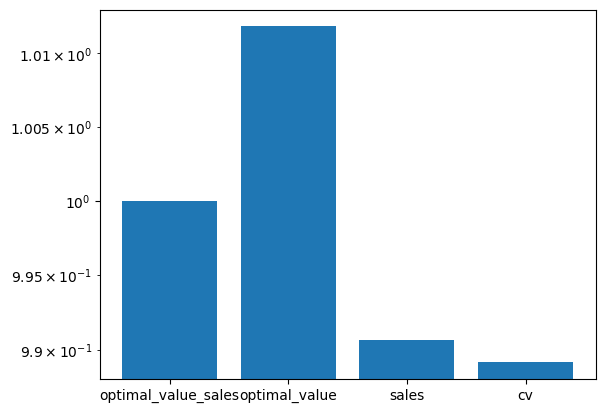

In [24]:
labels = ["optimal_value_sales", "optimal_value", "sales", "cv"]
values = [
    np.mean(optimal_value_sales_list),
    np.mean(optimal_value_list),
    np.mean(price_sales_list),
    np.mean(cv_list),
]

# グラフの描画
plt.bar(labels, values)

# logスケールに設定
plt.yscale("log")

# グラフの表示
plt.show()

In [14]:
import numpy as np
from numpy.typing import NDArray
from typing import Tuple, List
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

# ここでpredict_objective_functionを定義またはインポートしてください


def cross_validation_two_stage(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    prices_list: List[float],
) -> Tuple[float, List[np.ndarray], List[np.ndarray]]:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []
    optimal_prices_stage1_list = []
    optimal_prices_stage2_list = []
    bounds = [(0.6, 1.0) for _ in range(M)]

    for train_index, test_index in kf.split(X):
        # データの分割
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # 第1段階: 訓練データでモデルを学習
        lr_tilda = MultiOutputRegressor(LinearRegression())
        lr_tilda.fit(X_train, y_train)
        coefs_stage1 = [est.coef_ for est in lr_tilda.estimators_]
        intercepts_stage1 = [est.intercept_ for est in lr_tilda.estimators_]

        # 第1段階の価格最適化
        initial_prices = np.full(M, 0.6)
        result_stage1 = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts_stage1, coefs_stage1, M),
            bounds=bounds,
            method="SLSQP",
        )
        optimal_prices_stage1 = result_stage1.x

        # 第2段階: テストデータでモデルを学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)
        coefs_stage2 = [est.coef_ for est in lr_hat.estimators_]
        intercepts_stage2 = [est.intercept_ for est in lr_hat.estimators_]

        # 第2段階の価格最適化（第1段階の価格を初期値として使用）
        result_stage2 = minimize(
            predict_objective_function,
            optimal_prices_stage1,
            args=(intercepts_stage2, coefs_stage2, M),
            bounds=bounds,
            method="SLSQP",
        )
        optimal_prices_stage2 = result_stage2.x

        # 売上の評価
        quantity_hat = lr_hat.predict([optimal_prices_stage2])
        sales_hat = np.sum(quantity_hat * optimal_prices_stage2)
        optimal_sales_list.append(sales_hat)

        # 各段階の最適価格を保存
        optimal_prices_stage1_list.append(optimal_prices_stage1)
        optimal_prices_stage2_list.append(optimal_prices_stage2)

    average_sales = np.mean(optimal_sales_list)
    return average_sales, optimal_prices_stage1_list, optimal_prices_stage2_list


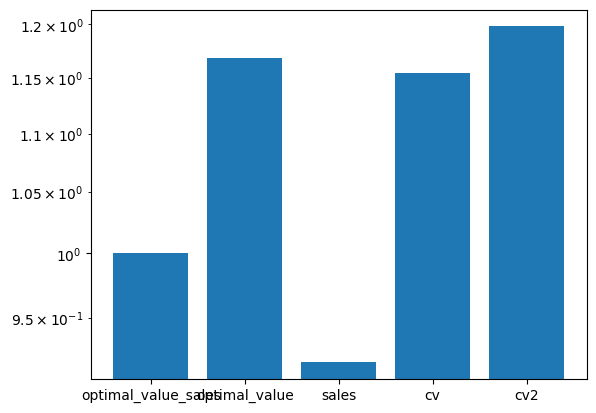

In [38]:
M = 20
alpha = alpha_star(M)
beta = beta_star(M, M)
r_m = 0.6
r_M = 1.0
price_list = []
quantity_list = []

for i in range(500):
    price = create_price(r_m, r_M, M)
    price_list.append(price)
    quantity = quantity_function(price, alpha, beta)
    quantity_list.append(quantity)

X = np.array(price_list).astype(float)
y = np.array(sales_list).astype(float)

z = [0.6, 0.7, 0.8, 0.9, 1.0]

# predict_optimize関数を使って最適化
optimal_value, optimal_prices = predict_optimize(M, X, y, z)

# sales_optimize関数を使って最適化
optimal_value_sales, optimal_prices_sales = sales_optimize(M, alpha, beta, z)

# optimal_pricesを使って売上を計算
sales = sum(sales_function(optimal_prices, alpha, beta))

# cross_validation関数を使ってクロスバリデーション
cv = cross_validation(X, y, M, 5, z)

# cross_validation_two_stage関数を使ってクロスバリデーション
cv2, _, _ = cross_validation_two_stage(X, y, M, 5, z)

# 結果を棒グラフで表示
labels = ["optimal_value_sales", "optimal_value", "sales", "cv", "cv2"]
values = [
    optimal_value_sales / optimal_value_sales,
    optimal_value / optimal_value_sales,
    sales / optimal_value_sales,
    cv / optimal_value_sales,
    cv2 / optimal_value_sales,
]

plt.bar(labels, values)
plt.yscale("log")
plt.show()


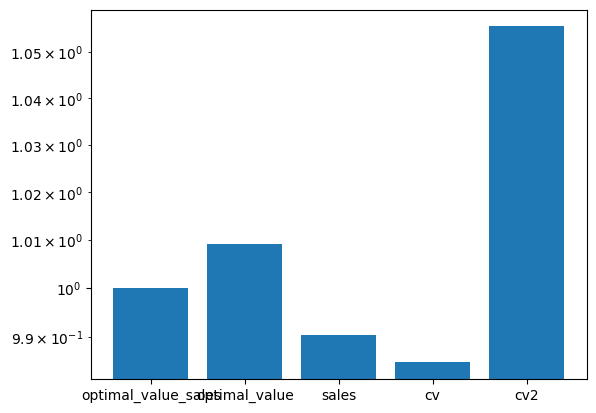

In [41]:
# M=20で100回実行し、平均をプロット
optimal_value_list = []
optimal_value_sales_list = []
sales_list = []
cv_list = []
cv2_list = []

for i in range(100):
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    price_list = []
    quantity_list = []

    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        quantity = quantity_function(price, alpha, beta)
        quantity_list.append(quantity)

    X = np.array(price_list).astype(float)
    y = np.array(quantity_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    optimal_value, optimal_prices = predict_optimize(M, X, y, z)
    optimal_value_sales, optimal_prices_sales = sales_optimize(M, alpha, beta, z)
    sales = sum(sales_function(optimal_prices, alpha, beta))
    cv = cross_validation(X, y, M, 5, z)
    cv2, _, _ = cross_validation_two_stage(X, y, M, 5, z)

    optimal_value_sales_list.append(optimal_value_sales / optimal_value_sales)
    optimal_value_list.append(optimal_value / optimal_value_sales)
    sales_list.append(sales / optimal_value_sales)
    cv_list.append(cv / optimal_value_sales)
    cv2_list.append(cv2 / optimal_value_sales)

labels = ["optimal_value_sales", "optimal_value", "sales", "cv", "cv2"]
values = [
    np.mean(optimal_value_sales_list),
    np.mean(optimal_value_list),
    np.mean(sales_list),
    np.mean(cv_list),
    np.mean(cv2_list),
]

plt.bar(labels, values)
plt.yscale("log")
plt.show()


In [42]:
def cross_validation_two_stage_modified(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    prices_list: List[float],
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []
    bounds = [(0.6, 1.0) for _ in range(M)]

    for train_index, test_index in kf.split(X):
        # データの分割
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # 第1段階: 訓練データでモデルを学習
        lr_model = MultiOutputRegressor(LinearRegression())
        lr_model.fit(X_train, y_train)
        coefs = [est.coef_ for est in lr_model.estimators_]
        intercepts = [est.intercept_ for est in lr_model.estimators_]

        # 価格の最適化
        initial_prices = np.full(M, 0.6)
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="SLSQP",
        )
        optimal_prices = result.x

        # 第2段階: テストデータでモデルを評価
        quantity_hat = lr_model.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)
        optimal_sales_list.append(sales_hat)

    average_sales = np.mean(optimal_sales_list)
    return average_sales


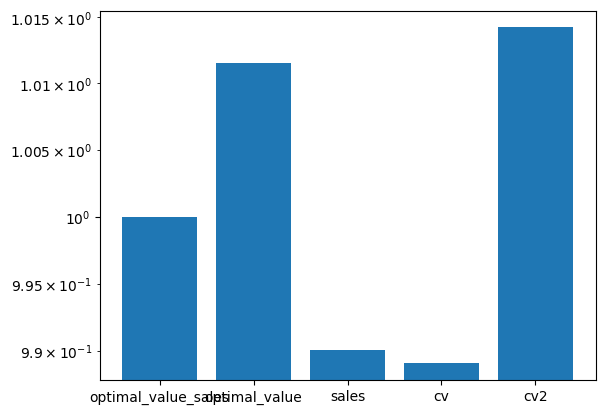

In [44]:
# 実験コード
# M=20で100回実行し、平均をプロット
optimal_value_list = []
optimal_value_sales_list = []
sales_list = []
cv_list = []
cv2_list = []

for _ in range(100):
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    price_list = []
    quantity_list = []

    for _ in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        quantity = quantity_function(price, alpha, beta)
        quantity_list.append(quantity)

    X = np.array(price_list).astype(float)
    y = np.array(quantity_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    optimal_value, optimal_prices = predict_optimize(M, X, y, z)
    optimal_value_sales, optimal_prices_sales = sales_optimize(M, alpha, beta, z)
    sales = sum(sales_function(optimal_prices, alpha, beta))
    cv = cross_validation(X, y, M, 5, z)
    cv2 = cross_validation_two_stage_modified(X, y, M, 5, z)

    optimal_value_sales_list.append(optimal_value_sales / optimal_value_sales)
    optimal_value_list.append(optimal_value / optimal_value_sales)
    sales_list.append(sales / optimal_value_sales)
    cv_list.append(cv / optimal_value_sales)
    cv2_list.append(cv2 / optimal_value_sales)

labels = ["optimal_value_sales", "optimal_value", "sales", "cv", "cv2"]
values = [
    np.mean(optimal_value_sales_list),
    np.mean(optimal_value_list),
    np.mean(sales_list),
    np.mean(cv_list),
    np.mean(cv2_list),
]

plt.bar(labels, values)
plt.yscale("log")
plt.show()


In [45]:
def cross_validation_two_stage(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    prices_list: List[float],
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []
    bounds = [(0.6, 1.0) for _ in range(M)]

    for train_index, test_index in kf.split(X):
        # データの分割
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # 第1段階: 訓練データでモデルを学習
        lr_train = MultiOutputRegressor(LinearRegression())
        lr_train.fit(X_train, y_train)
        coefs_train = [est.coef_ for est in lr_train.estimators_]
        intercepts_train = [est.intercept_ for est in lr_train.estimators_]

        # 第1段階の価格最適化
        initial_prices = np.full(M, 0.6)
        result_stage1 = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts_train, coefs_train, M),
            bounds=bounds,
            method="SLSQP",
        )
        optimal_prices_stage1 = result_stage1.x

        # 第2段階: テストデータでモデルを再学習
        lr_test = MultiOutputRegressor(LinearRegression())
        lr_test.fit(X_test, y_test)
        coefs_test = [est.coef_ for est in lr_test.estimators_]
        intercepts_test = [est.intercept_ for est in lr_test.estimators_]

        # 第2段階の価格最適化（第1段階の最適価格を初期値として使用）
        result_stage2 = minimize(
            predict_objective_function,
            optimal_prices_stage1,
            args=(intercepts_test, coefs_test, M),
            bounds=bounds,
            method="SLSQP",
        )
        optimal_prices_stage2 = result_stage2.x

        # 売上の評価
        quantity_hat = lr_test.predict([optimal_prices_stage2])
        sales_hat = np.sum(quantity_hat * optimal_prices_stage2)
        optimal_sales_list.append(sales_hat)

    average_sales = np.mean(optimal_sales_list)
    return average_sales


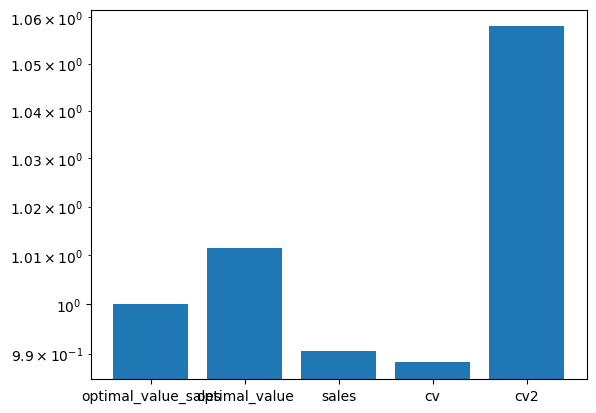

In [46]:
# 実験コード
# M=20で100回実行し、平均をプロット
optimal_value_list = []
optimal_value_sales_list = []
sales_list = []
cv_list = []
cv2_list = []

for _ in range(100):
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    price_list = []
    quantity_list = []

    for _ in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        quantity = quantity_function(price, alpha, beta)
        quantity_list.append(quantity)

    X = np.array(price_list).astype(float)
    y = np.array(quantity_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    optimal_value, optimal_prices = predict_optimize(M, X, y, z)
    optimal_value_sales, optimal_prices_sales = sales_optimize(M, alpha, beta, z)
    sales = sum(sales_function(optimal_prices, alpha, beta))
    cv = cross_validation(X, y, M, 5, z)
    cv2 = cross_validation_two_stage(X, y, M, 5, z)

    optimal_value_sales_list.append(optimal_value_sales / optimal_value_sales)
    optimal_value_list.append(optimal_value / optimal_value_sales)
    sales_list.append(sales / optimal_value_sales)
    cv_list.append(cv / optimal_value_sales)
    cv2_list.append(cv2 / optimal_value_sales)

labels = ["optimal_value_sales", "optimal_value", "sales", "cv", "cv2"]
values = [
    np.mean(optimal_value_sales_list),
    np.mean(optimal_value_list),
    np.mean(sales_list),
    np.mean(cv_list),
    np.mean(cv2_list),
]

plt.bar(labels, values)
plt.yscale("log")
plt.show()
